# Current-Based Spiking Neural Network ($\textit{d}$-dimensional input signal)

The following code simulates a Coördinated Spiking Model with $\textit{N}$ neurons and a $\textit{d}$-dimensional input. The model contains the following functions:

- initialize_weights: initialize weights for the different neurons
- initialize_params_N: initialize the variables and parameters for simulating the network
- TVS_N: creates sinusoidal input signal with $\textit{d}$ dimensions
- run_N: runs the spiking network model
- plot_N: plots the results (input + input estimate, spike trains and voltages)

In addition, other functions have been added to plot the parameters of the network:
- plot_weights: plot the weights for a 2- and 3- dimensional input signal.
- plot_boundary: plot the error space with the error boundaries for the different neurons

Install required packages

In [1]:
import numpy as np
import pylab as pl
import math
from matplotlib import colors as mcolors
from mpl_toolkits.mplot3d import Axes3D
import random
import os

# # enable HoloView
# import pandas as pd
# import holoviews as hv
# from holoviews import opts
# from bokeh.io import curdoc
# from bokeh.layouts import layout
# from bokeh.models import Slider, Button
# hv.extension('bokeh')

# enable animation
import matplotlib.animation as animation

# # enable interactive plot
# %matplotlib notebook

Function used for plotting the spike trains

In [2]:
def zero_to_nan(values):
    """Replace every 0 with 'nan' and return a copy."""
    
    return [float('nan') if x==0 else x for x in values]

## $\textit{N}$-neurons

Initialize weights

In [3]:
def initialize_weights(N, d):
    """ Initialize decoding weights of the different neurons. """
    
    if d == 1:
        # 1-dimensional input signal
        
        weights = np.linspace(0, 2 * np.pi, N + 1)
        D = [np.cos(weight) for weight in weights[0:N]]
        D = np.asarray(D).reshape((N, d))
        
    elif d == 2:
        # 2-dimensional input signal
        
        weights = np.linspace(0, 2 * np.pi, N + 1)       
        D = np.zeros((N,d ))
        D[:, 0] = [np.sin(weight) for weight in weights[0:N]]
        D[:, 1] = [np.cos(weight) for weight in weights[0:N]]
        
    else:
        D = np.random.normal(0, 0.4, size=(N, d)) 
               
    return D

Initialize parameters

In [4]:
def initialize_params_N(N, d, iterations, dt, D, beta):
    """ Initialize variables and parameters. """
    
    # timesteps
    t = np.arange(0, iterations) * dt

    # voltage
    voltage = np.zeros((N, iterations))

    # input estimate
    if d > 1:
        x_est = np.zeros((d, iterations))
    else:
        x_est = np.zeros(iterations)

    # spike train
    o = np.zeros((N, iterations))

    # threshold
    T = [(np.dot(weight, weight) + beta)/2 for weight in D]

    return (t, voltage, x_est, o, T)

In [5]:
def TVS_N(iterations):
    "Create time varying signal following a sinusoidal function. "
    
    c = []
    x = []
    
    # number of sinus periods (total # of sinus periods = 2 * cycles)
    cycles = 2
    t = np.linspace(0, np.pi, d + 1)       # starting points of d-dimensioan sinusoidal input signals
    
    for i in range(d):
        
        x_temp = np.sin(2 * np.linspace(-cycles * np.pi, cycles * np.pi, iterations) + t[i])
        dxdt = np.diff(x_temp)/dt
        c_temp = x_temp[:-1] + dxdt

        c.extend(c_temp)
        x.extend(x_temp)
    
    if d > 1:
        c = np.asarray(c).reshape((d, iterations - 1))
        x = np.asarray(x).reshape((d, iterations))

    return(c, x)

In [6]:
def run_N(tau, beta):
    """ Run simulation with time constant, tau, and constant for the cost, beta. """
    
    for t in range(1, iterations):
        
        if d > 1:
        # input signal with dimensions > 1
            
            # update input estimate
            reset = np.zeros((1, d))
            for i in range(N):
                if o[i, t - 1] > 0:
                    reset = np.dot(D[i, :], o[i, t - 1])
            dxestdt = (-1/tau) * x_est[:, t - 1] + reset
            x_est[:, t] = x_est[:, t - 1] + dt * dxestdt
            
            # update voltages
            reset = 0
            for i in range(N):
                 if o[i, t - 1] > 0:
                        reset = np.dot(D, D[i, :]) * o[i, t - 1]
            dVdt = (-1/tau) * voltage[:, t - 1] + np.dot(D, c[:,t - 1]) - reset
            voltage[:, t] = voltage[:, t - 1] + dt * dVdt
         
        else:
        # input signal with 1 dimension

            # update input estimate
            dxestdt = (-1/tau) * x_est[t - 1] + np.dot(D.T, o[:, t - 1])
            x_est[t] = x_est[t - 1] + dt * dxestdt

            # update voltage
            dVdt = (-1/tau) * voltage[:, t - 1] + np.dot(D, c[t - 1]).T - np.dot(D.T ** 2, o[:, t - 1])
            voltage[:, t] = voltage[:, t - 1] + dt * dVdt

        # check for neurons with voltages above threshold
        neurons = np.arange(0, N, 1)
        above_threshold = neurons[np.where(voltage[:, t] > T)]

        # reset neurons' voltages when threshold is exceeded
        if len(above_threshold) > 0:

            # select spiking neuron
            spike_neuron = np.random.choice(above_threshold)
            
            # update spikes
            o[spike_neuron, t] = 1/dt

In [7]:
def plot_N(color, plot_voltage=1):
    """ Plots the results, including input and input estimate per dimension 
        as well as the spike trains and voltages of the individual neurons. """
    
    # determine number of plots
    if plot_voltage == 1:
        plot = d + N + 1
    else:
        plot = d + 1
    
    pl.subplots(plot, 1, figsize=(12, 16))
    pl.subplots_adjust(hspace=0.2 * N)
    counter = 1
    
    # enable LaTeX
    pl.rc('text', usetex=True)
    
    # plot input and input estimate per dimension over time
    if d > 1:
        # input signal with dimensions > 1
        
        for i in range(1, d + 1):
            # input signal with more than 1 dimension
            pl.subplot(plot, 1, counter)
            pl.plot(x_est[i - 1,:], label=r'$\hat{x}_{%i}$' %i, color='gray')
            pl.plot(x[i - 1,:], label='$x_{%i}$' %i, color='k')
            pl.yticks([])
            pl.xticks([])
            pl.legend()
            counter = counter + 1
    else:
        # input signal with 1 dimension
        pl.subplot(plot, 1, counter)
        pl.plot(x_est, label=r'$\hat{x}$', color='gray')
        pl.plot(x, label='$x$', color='k')
        pl.yticks([])
        pl.xticks([])
        pl.legend()
        counter = counter + 1
    
    # plot spike trains per neuron over time
    fig = pl.subplot(plot, 1, counter)
    
    for i in range(1, N + 1):
        values = zero_to_nan(o[i - 1, :] * i)
        pl.scatter(np.arange(0, iterations), values, color=color[i - 1][:]/255, label='N%i' %i, s=1.5)
    
    pl.title('Spike train', fontsize=15)
    pl.yticks([])
    pl.xticks([])
    pl.xlim(0, iterations)
    pl.legend()
    
    counter = counter + 1
    
    if plot_voltage == 1: 
        # plot voltage per neuron over time
        for i in range(1, N + 1):
            pl.subplot(plot, 1, counter)
            pl.plot(voltage[i - 1], color=color[i - 1][:]/255, label='voltage')
            pl.plot(np.arange(0, iterations), np.ones(iterations) * T[i - 1], color='gray', label='threshold')
            pl.xlim(0, iterations)
            pl.ylabel('Voltage')
            pl.title('Neuron %i' %i,  fontsize=15)
            pl.legend()
            counter = counter + 1
        
    pl.xlabel('time')

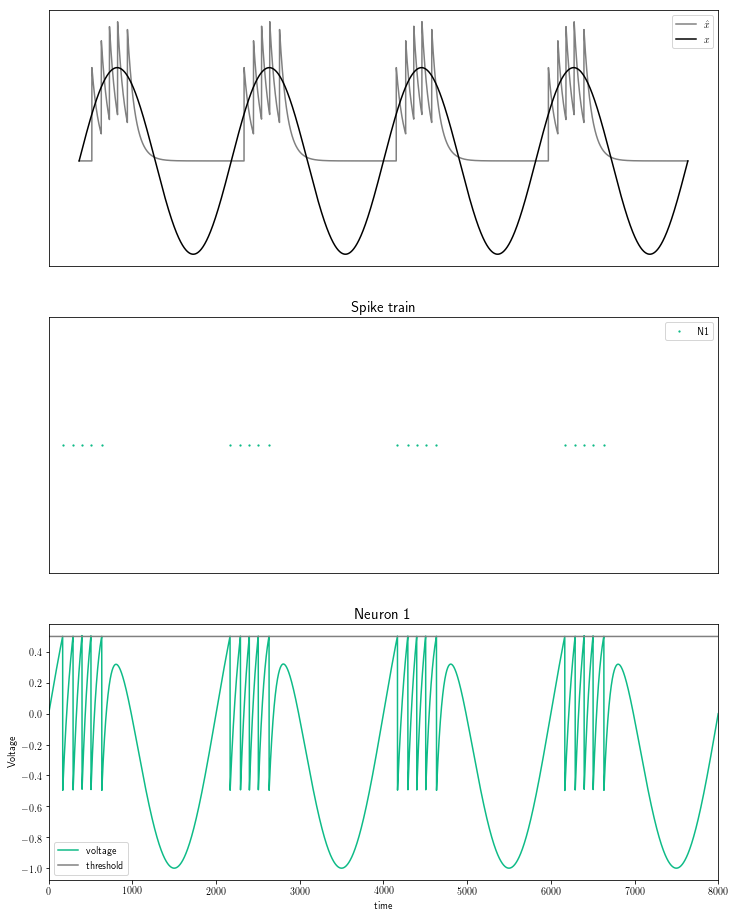

In [9]:
# Run simulation and plot results for given parameters
N = 1                                                   # number of neurons
d = 1                                                    # number of dimensions of signal input
iterations = 8000                                        # number of time steps
dt = 0.01                                                # step size
tau = 1                                                  # time constant
beta = 0.0                                               # cost 
color = np.random.randint(0, 255, size=(N, 3))           # color map for plotting the different neurons

# run simulation
D = initialize_weights(N, d)                                                # initialize decoding weights
t, voltage, x_est, o, T = initialize_params_N(N, d, iterations, dt, D, beta)# initialize parameters
c, x = TVS_N(iterations)                                                    # create d-dimensional input signal
run_N(tau, beta)                                                            # run spiking network
plot_N(color, plot_voltage=1)                                               # plot results

## Plot firing rate

In [19]:
# exponential filter
def exponential_filter(t, tau=1):
    return np.exp(-t/tau)

# initialize filter
def initialize_filter(x, tau = 2):
    return [exponential_filter(i, tau) for i in x]

# compute firing rate
def firing_rate(spike_train, filt):
    return np.convolve(spike_train, filt)

In [20]:
# times = np.arange(0,iterations + 1)
# x = np.linspace(0, 200, 1000)
# y = initialize_filter(x)

# plots = N
# pl.subplots(plots, 1)
# counter = 1

# for i in range(N):
#     # spiketimes = times[np.where(o[i, :]==100)[0]]
    
#     firingrate = firing_rate(o[i, :], y)
    
#     pl.subplot(plots, 1, counter)
#     counter = counter + 1
#     pl.plot(firingrate[0:iterations], color=color[i][:]/255)


Plot the weights of the neurons for a 2- or 3-dimensional input

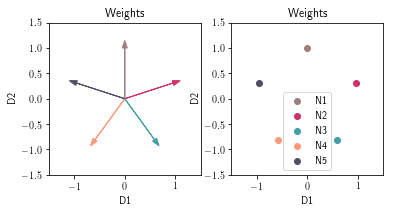

In [36]:
def plot_weights():
    """ Plot the weights for N neurons (2D and 3D input signal). """
        
    if d == 2:
    # 2-dimensional input signal
        
        plots = 2
        pl.subplots(plots, 1) # figsize=(12, 4)
   
        # plot weights as arrows
        pl.subplot(1, 2, 1)
        pl.axis('square')
        for i in range(1, N + 1):
            arrow = pl.arrow(0, 0, D[i - 1, 0], D[i - 1, 1], color=color[i - 1][:]/255, head_width=0.1)
        pl.xlabel('D1')
        pl.ylabel('D2')
        pl.title('Weights')
        pl.xlim(-1.5, 1.5)
        pl.ylim(-1.5, 1.5)

        # plot weights as points
        pl.subplot(1, 2, 2)
        pl.axis('square')
        for i in range(1, N + 1):
            pl.scatter(D[i - 1][0], D[i - 1][1], color=color[i - 1][:]/255, label='N%i' %i)
        pl.xlabel('D1')
        pl.ylabel('D2')
        pl.xlim(-1.5, 1.5)
        pl.ylim(-1.5, 1.5)
        pl.title('Weights')
        #pl.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=15, markerscale=1)
        pl.legend()
        
    elif d == 3:
    # 3-dimensional input signal
        
        fig = pl.figure()
        ax = pl.axes(projection='3d')
        
        # plot weights as points
        for i in range(1, N + 1):
            ax.scatter3D(D[i - 1][0], D[i - 1][1], D[i - 1][2], color=color[i - 1][:]/255, s=50, label='N%i' %i)
        ax.set_xlabel('D1')
        ax.set_ylabel('D2')
        ax.set_zlabel('D3')
        pl.title('Weights',fontsize=20)
        #pl.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=15, markerscale=1)
        pl.legend()
    else:
        print("No plot generated: function for 2D and 3D signal input only. ")
        
plot_weights()

## Bounding box

2-dimensional input

(2, 8000)


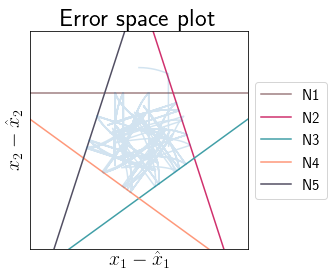

In [37]:
def plot_bounding_box_2D(arrow=0, error=0):
    """ Plots 2D error space with the bounding box with (arrow=1) or without (arrow=0) the weights of neurons. """
    
    if d == 2:
    # check for 2-dimensional input signal
    
        # enable LaTeX
        pl.rc('text', usetex=True)
        
        # initialize figure
        fig = pl.figure()
        #fig = pl.figure(figsize=(16,9))
        pl.axis('square')

        # plot bouding box
        x1 = np.linspace(-10, 10, d)
        for i in range(1, N + 1):
            x2 = np.zeros(d)
            for j in range(d):
                x2[j] = (T[i - 1] - x1[j] * D[i - 1, 0]) / D[i - 1, 1]
            pl.plot(x1, x2, label="N%i" %i, color=color[i - 1]/255)
        pl.yticks([])
        pl.xticks([])
        pl.xlim(-1.5, 1.5)
        pl.ylim(-1.5, 1.5)
        pl.xlabel('$x_{1} - \hat{x}_{1}$', fontsize=20)
        pl.ylabel('$x_{2} - \hat{x}_{2}$', fontsize=20)
        pl.title('Error space plot', fontsize=25)
        pl.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=15, markerscale=1)

        # plot signal representtation error over time (if error = 1)
        if error == 1:
            start = 200
            error = x[:, :] - x_est[:, :]
            pl.plot(error[0], error[1], alpha = 0.2)
        
        # plot arrow plot weights (if arrow = 1)
        if arrow == 1:
            for i in range(1, N + 1):
                arrow = pl.arrow(0, 0, D[i - 1, 0], D[i - 1, 1], color=color[i - 1][:]/255, head_width=0.1)
            
    else:
        print("2D signal input only. ")
    
plot_bounding_box_2D(arrow=0, error=1)
print(x.shape)

3-dimensional input

In [25]:
def plot_bounding_box_3D_I(error=0):
    """ Plots 2D error space with the bounding box with (arrow=1) or without (arrow=0) the weights of neurons. """
            
    if d == 3:
    # check for 3-dimensional input signal
    
        # enable LaTeX
        pl.rc('text', usetex=True)

        # initiate 3D
        fig = pl.figure(figsize=(8,6))
        
        ax = pl.axes(projection='3d')
        pl.title('Erros space plot', fontsize=15)
        ax.set_xlabel('$x_{1} - \hat{x}_{1}$')
        ax.set_ylabel('$x_{2} - \hat{x}_{2}$')
        ax.set_zlabel('$x_{3} - \hat{x}_{3}$')

        # plot weights as points
        for i in range(1, N + 1):
            ax.scatter3D(D[i - 1][0], D[i - 1][1], D[i - 1][2], color=color[i - 1][:]/255, s=50, label='N%i' %i)
        pl.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=15, markerscale=1)
        
        # plot signal representtation error over time (if error = 1)
        if error == 1:
            start = 200
            error = x[:, start: iterations] - x_est[:, start:iterations]
            #pl.plot(error[2, :], error[0, :], error[1, :], color='gray', alpha = 0.8)
            ax.scatter(error[0, :], error[1, :], error[2, :], alpha = 0.2)
        
    else:
        print("3D signal input only. ")

plot_bounding_box_3D_I(error=1)

3D signal input only. 


In [26]:
def plot_bounding_box_3D_II():
    
    if d == 3:
        # enable LaTeX
        pl.rc('text', usetex=True)

        # initialize plots   
        plots = d
        pl.subplots(plots, 1, figsize=(8, 12))

        # compute error
        error = x - x_est

        # plot error
        pl.subplot(plots, 1, 1)
        pl.plot(error[0, :], error[1, :], alpha = 0.2)
        pl.xlim(-1, 1)
        pl.ylim(-1, 1)
        pl.xlabel('$x_{1} - \hat{x}_{1}$', fontsize=20)
        pl.ylabel('$x_{2} - \hat{x}_{2}$', fontsize=20)

        pl.subplot(plots, 1, 2)
        pl.plot(error[1, :], error[2, :], alpha = 0.2)
        pl.xlim(-1, 1)
        pl.ylim(-1, 1)
        pl.xlabel('$x_{2} - \hat{x}_{2}$', fontsize=20)
        pl.ylabel('$x_{3} - \hat{x}_{3}$', fontsize=20)

        pl.subplot(plots, 1, 3)
        pl.plot(error[2, :], error[0, :], alpha = 0.2)
        pl.xlim(-1, 1)
        pl.ylim(-1, 1)
        pl.xlabel('$x_{3} - \hat{x}_{3}$', fontsize=20)
        pl.ylabel('$x_{1} - \hat{x}_{1}$', fontsize=20)
        
        
    else:
        print('3D signal input only.')
    
plot_bounding_box_3D_II()

3D signal input only.


In [32]:
def spike_plot():
    colors_hv = hv.core.options.Cycle.default_cycles['default_colors'] 
    out = hv.Overlay()

    times = np.arange(0,iterations + 1)

    for i in range(o.shape[0]):
        
        spiketimes = times[np.where(o[i, :]==100)[0]]

        if len(spiketimes) > 0:
            opts = hv.opts.Scatter(color=colors_hv[i%len(colors_hv)], ylim=(0, N + 1))
            out = out * hv.Scatter(
                zip(spiketimes, np.ones(len(spiketimes)) * (i + 1)),
                   kdims='Time',
                   vdims='Neuron', group='spikes').opts(opts)

    return out

# out = spike_plot()
# out

C:\Users\amber\Anaconda3\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.PillowWriter'>


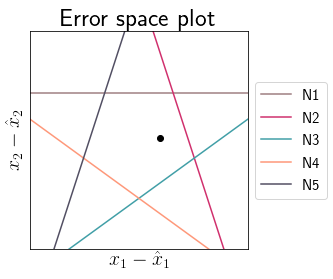

In [38]:
def bounding_box_animation_2D(filename='BB.gif', arrow=0, frames=4000, interval=100):
    
    #pl.rcParams['animation.convert_path'] = 'magick'

    # initiate plot
    fig = pl.figure()# figsize = (5,5)
    pl.axis('square')
    axes = fig.add_subplot(111)
    
    # file
    file = 'C:/Users/amber/MachensLab/error_space(t)_gif/' + filename + '.gif'

    # compute representation error over time
    start = 400
    error = x[:, start:iterations] - x_est[:, start:iterations]
    error_x1 = error[0]
    error_x2 = error[1]
    point, = axes.plot([error_x1[0]],[error_x2[0]], 'ko')
    
    # returns coördinates error over time
    def ani(coords):
        point.set_data([coords[0]],[coords[1]])
        point.axes.axis([-1.5, 1.5, -1.5, 1.5])
        return point

    # return position error over time
    def frames():
        for error_x1_pos, error_x2_pos in zip(error_x1, error_x2):
            yield error_x1_pos, error_x2_pos
            
    # plot boundary box
    x1 = np.linspace(-10, 10, 2)
    x2 = np.zeros(2)
    for i in range(1, N + 1):
        for j in range(2):
            x2[j] = (T[i - 1] - x1[j] * D[i - 1, 0]) / D[i - 1, 1]
        pl.plot(x1, x2, label="N%i" %i, color=color[i - 1]/255)
    pl.yticks([])
    pl.xticks([])
    pl.xlim(-1.5, 1.5)
    pl.ylim(-1.5, 1.5)
    pl.xlabel('$x_{1} - \hat{x}_{1}$', fontsize=20)
    pl.ylabel('$x_{2} - \hat{x}_{2}$', fontsize=20)
    pl.title('Error space plot', fontsize=25)
    pl.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=15, markerscale=1)

    # plot weights as arrows
    if arrow == 1:
        for i in range(1, N + 1):
                arrow = pl.arrow(0, 0, D[i - 1, 0], D[i - 1, 1], color=color[i - 1][:]/255, head_width=0.1)
            
    # runs animation
    ani = animation.FuncAnimation(fig, ani, frames=frames, interval=interval)
    ani.save(file, writer='imagemagick') # save as .gif
    pl.show()
    
bounding_box_animation_2D('D2_N5')